In [1]:
from utils.create_embedding_feautres import create_embedding_features
from utils.dvrl_utils import calc_qwk, get_dev_sample, fit_func, pred_func, remove_top_p_sample
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix

/Users/takumishibata/.pyenv/versions/3.12.0/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## memo

-p1 80%
-p2 60%
-p3 70%
-p4 50%
-p5 60%
-p6 10%
-p7 30%
-p8 30%

## （実験１）問題ごとの採択比率の分析

load data from data/cross_prompt_attributes/1/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1065, 653, 689, 446, 939, 1548, 1244, 452, 1447, 916, 945, 871, 878, 1368, 476, 746, 1645, 1299, 1509, 282, 151, 1549, 622, 1347, 915, 1570, 690, 1348, 305, 1359]
source_data_prompts len: 11193
target_data_prompts len: 1753
load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [363, 1298, 1140, 955, 765, 995, 244, 1215, 988, 573, 1398, 182, 900, 1195, 310, 519, 1710, 1515, 1622, 1632, 725, 1055, 502, 1276, 1006, 1000, 1198, 1333, 366, 1526]
source_data_prompts len: 11178
target_data_prompts len: 1768
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1488, 785, 1005, 396, 28, 960, 1302, 1434, 1387, 941, 1576, 1327, 914, 1620, 1673, 1422, 1529, 485, 530, 1278, 1573, 101, 942, 1035, 173, 592, 1571, 1227, 409, 13

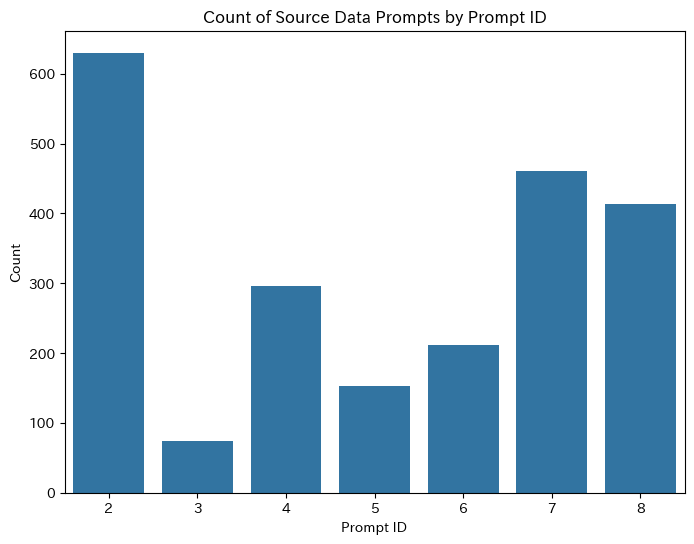

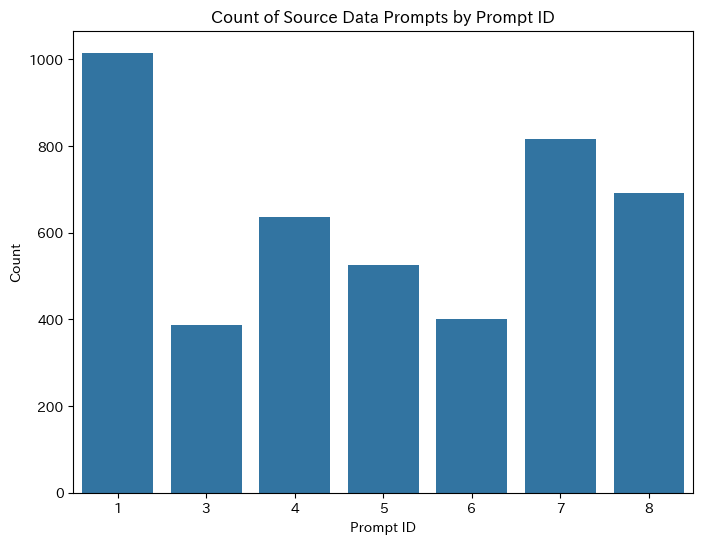

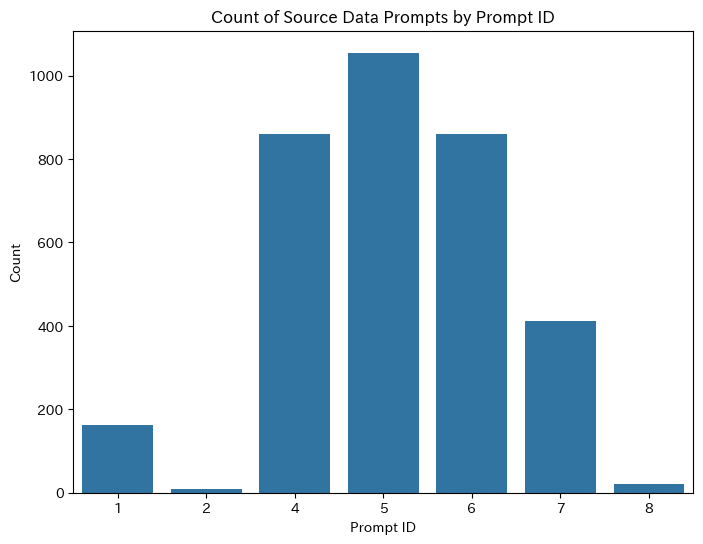

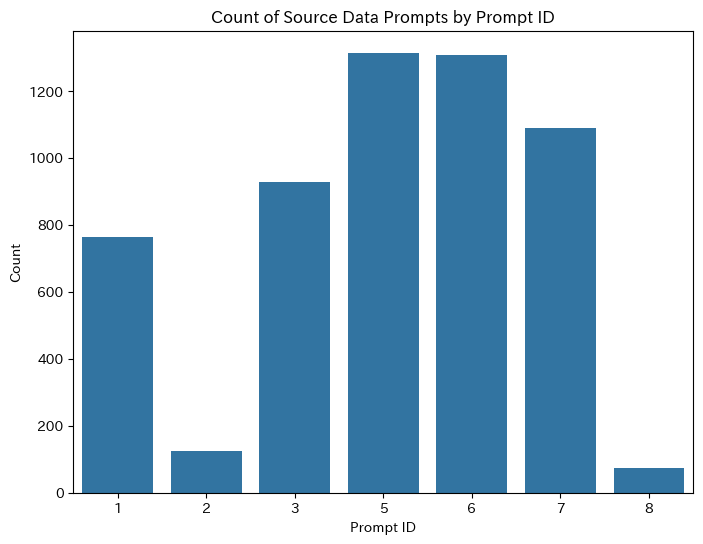

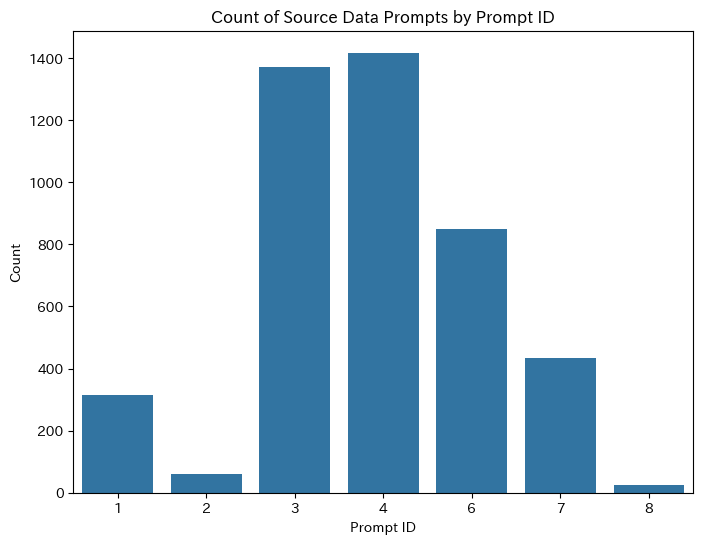

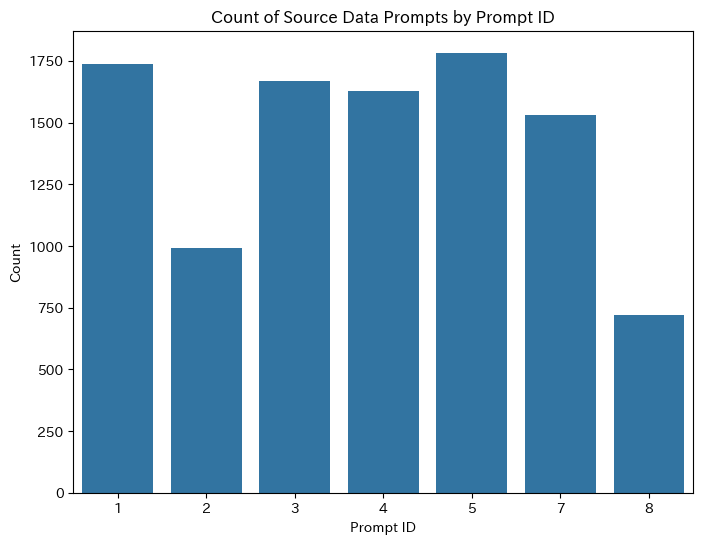

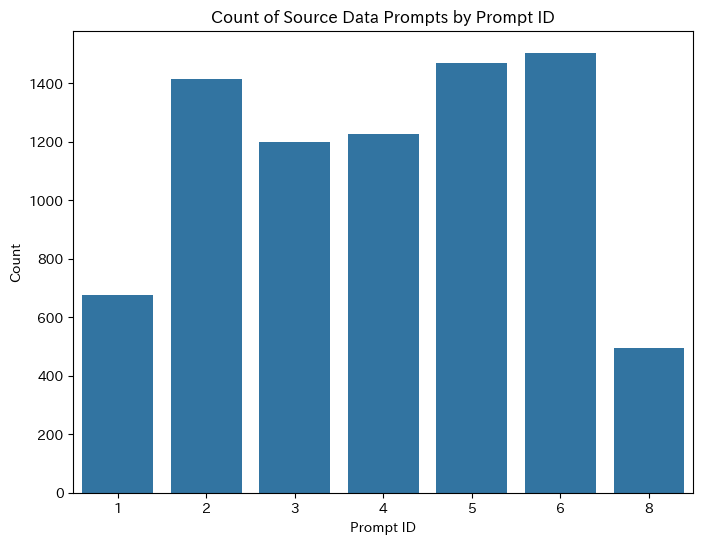

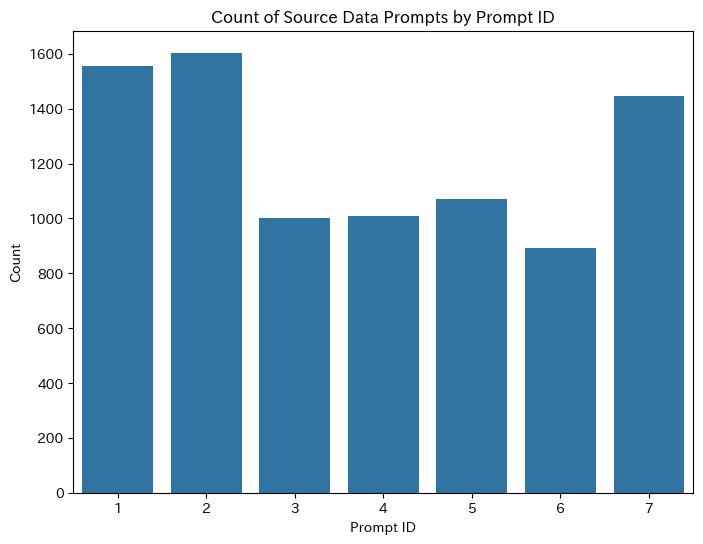

In [3]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
top_p_list = [0.8, 0.6, 0.7, 0.5, 0.6, 0.1, 0.3, 0.3]

prompt_arr = []
num_prompts = []
for test_prompt_id, top_p in zip(test_prompt_ids, top_p_list):
    train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
    # split test data into dev and test
    x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

    weights = remove_top_p_sample(np.load('outputs/Estimated_Data_Values/DVRL-word/' + f'estimated_data_value{test_prompt_id}.npy'), top_p=top_p, ascending=False)

    source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)
    target_data_prompts = np.array(test_data['essay_set'])[test_idx]

    print('source_data_prompts len:', len(source_data_prompts))
    print('target_data_prompts len:', len(target_data_prompts))
    num_prompts.append(len(target_data_prompts))

    source_data_prompts = source_data_prompts[weights == 1]

    # Count the occurrences of each unique value in source_data_prompts
    unique, counts = np.unique(source_data_prompts, return_counts=True)
    # Plot the counts
    plt.figure(figsize=(8, 6))
    sns.barplot(x=unique, y=counts)
    plt.xlabel('Prompt ID')
    plt.ylabel('Count')
    plt.title('Count of Source Data Prompts by Prompt ID')
    # plt.savefig('outputs/figures/' + f'count_of_source_data_prompts_by_prompt_id{test_prompt_id}.png')

    count_list = counts.tolist()
    count_list.insert(test_prompt_id-1, 0)
    prompt_arr.append(count_list)


In [4]:
num_prompts = np.array(num_prompts).reshape(1, -1)
num_prompts

array([[1753, 1768, 1696, 1742, 1775, 1770, 1539,  693]])

In [5]:
prompt_arr = np.array(prompt_arr, dtype=float)
prompt_arr

array([[   0.,  630.,   74.,  296.,  153.,  212.,  461.,  413.],
       [1015.,    0.,  388.,  635.,  525.,  401.,  817.,  691.],
       [ 162.,    8.,    0.,  860., 1055.,  859.,  412.,   20.],
       [ 765.,  124.,  927.,    0., 1314., 1308., 1090.,   74.],
       [ 315.,   59., 1371., 1417.,    0.,  848.,  435.,   24.],
       [1738.,  993., 1668., 1629., 1783.,    0., 1529.,  719.],
       [ 677., 1415., 1200., 1227., 1469., 1504.,    0.,  493.],
       [1557., 1604., 1001., 1008., 1071.,  892., 1445.,    0.]])

In [14]:
# 各問題の採択数を正規化
normalized_arr = prompt_arr / num_prompts
normalized_arr

array([[0.        , 0.35633484, 0.04363208, 0.16991963, 0.08619718,
        0.11977401, 0.29954516, 0.5959596 ],
       [0.57900742, 0.        , 0.22877358, 0.36452354, 0.29577465,
        0.22655367, 0.5308642 , 0.997114  ],
       [0.09241301, 0.00452489, 0.        , 0.49368542, 0.5943662 ,
        0.48531073, 0.2677063 , 0.02886003],
       [0.43639475, 0.07013575, 0.54658019, 0.        , 0.74028169,
        0.73898305, 0.70825211, 0.10678211],
       [0.17969196, 0.03337104, 0.80837264, 0.81343284, 0.        ,
        0.47909605, 0.28265107, 0.03463203],
       [0.99144324, 0.56165158, 0.98349057, 0.93513203, 1.00450704,
        0.        , 0.99350227, 1.03751804],
       [0.38619509, 0.80033937, 0.70754717, 0.7043628 , 0.82760563,
        0.84971751, 0.        , 0.71139971],
       [0.88819167, 0.90723982, 0.59021226, 0.57864524, 0.60338028,
        0.5039548 , 0.93892138, 0.        ]])

In [10]:

conmat = normalized_arr / normalized_arr.sum(axis=1).reshape(-1, 1)
conmat

array([[0.        , 0.21320021, 0.02610569, 0.10166534, 0.051573  ,
        0.0716625 , 0.17922214, 0.35657112],
       [0.17967028, 0.        , 0.07099013, 0.11311434, 0.09178106,
        0.07030128, 0.16473108, 0.30941183],
       [0.04698489, 0.00230056, 0.        , 0.25100097, 0.30218938,
        0.24674309, 0.13610801, 0.0146731 ],
       [0.1303679 , 0.02095224, 0.16328452, 0.        , 0.22115061,
        0.22076266, 0.21158214, 0.03189992],
       [0.06829154, 0.01268259, 0.30722028, 0.3091434 , 0.        ,
        0.18207942, 0.10742093, 0.01316183],
       [0.15235991, 0.08631173, 0.15113779, 0.14370629, 0.15436749,
        0.        , 0.15267633, 0.15944045],
       [0.07743777, 0.16047975, 0.14187356, 0.14123505, 0.16594704,
        0.17038079, 0.        , 0.14264605],
       [0.17726447, 0.18106608, 0.11779401, 0.11548548, 0.12042208,
        0.10057883, 0.18738906, 0.        ]])

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8')])

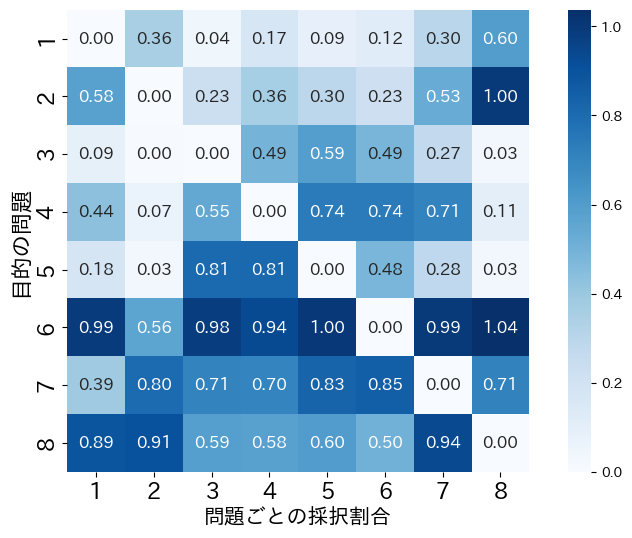

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    normalized_arr,
    # conmat,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    annot_kws={'size': 12}
)
plt.xlabel('問題ごとの採択割合', fontsize=15)
plt.ylabel('目的の問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.savefig('outputs/figures/' + f'prompt_usage_rate.png')

## （実験２）回答文の特徴分布の差を問題ごとに計算する

In [8]:
import numpy as np

def gaussian_kernel(x1, x2, sigma=1.0):
    """
    Compute the Gaussian kernel between two vectors.
    
    Args:
        x1: First vector.
        x2: Second vector.
        sigma: Bandwidth of the Gaussian kernel.
        
    Returns:
        The Gaussian kernel between x1 and x2.
    """
    diff = np.linalg.norm(x1 - x2)
    return np.exp(-diff ** 2 / (2 * sigma ** 2))

def squared_MMD(
    source: np.ndarray,
    target: np.ndarray,
    kernel: callable = gaussian_kernel
) -> float:
    """
    Compute the squared maximum mean discrepancy (MMD) between source and target.
    
    Args:
        source: Source data.
        target: Target data.
        kernel: Kernel function.
        
    Returns:
        The squared MMD between source and target.
    """
    m = len(source)
    n = len(target)
    
    mmd_ss = 0.0
    mmd_tt = 0.0
    mmd_st = 0.0

    for i in range(m):
        for j in range(m):
            mmd_ss += kernel(source[i], source[j])
    mmd_ss *= 1.0 / m ** 2
    
    for i in range(n):
        for j in range(n):
            mmd_tt += kernel(target[i], target[j])
    mmd_tt *= 1.0 / n ** 2
    
    for i in range(m):
        for j in range(n):
            mmd_st -= kernel(source[i], target[j])
    mmd_st *= 2.0 / (m * n)
    
    return mmd_ss + mmd_tt + mmd_st

In [19]:
test_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]
source_prompt_ids = [1, 2, 3, 4, 5, 6, 7, 8]

mmd_matrix = np.zeros((8, 8))
for source_prompt_id in source_prompt_ids:
    for test_prompt_id in test_prompt_ids:
        if test_prompt_id == source_prompt_id:
            continue
        train_data, valid_data, test_data = create_embedding_features(f'data/cross_prompt_attributes/{test_prompt_id}/', 'score', 'microsoft/deberta-v3-large', 'cpu')
        # split test data into dev and test
        x_dev, x_test, y_dev, y_test, dev_idx, test_idx = get_dev_sample(test_data['essay'], test_data['normalized_label'], dev_size=30)

        source_data_prompts = np.concatenate([train_data['essay_set'], valid_data['essay_set']], axis=0)

        source_data_rep = np.concatenate([train_data['essay'], valid_data['essay']], axis=0)[source_data_prompts == source_prompt_id]
        target_data_rep = np.array(test_data['essay'])

        mmd = squared_MMD(source_data_rep, target_data_rep)
        mmd_matrix[test_prompt_id-1, source_prompt_id-1] = mmd
        print(f'MMD between prompt {source_prompt_id} and prompt {test_prompt_id}: {mmd}')

load data from data/cross_prompt_attributes/2/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [341, 1298, 765, 955, 244, 995, 900, 1215, 1398, 573, 988, 182, 1140, 1195, 310, 519, 1710, 1515, 1622, 1632, 725, 1055, 1629, 1000, 1006, 1276, 1198, 502, 366, 1333]
MMD between prompt 1 and prompt 2: 0.023901703138679675
load data from data/cross_prompt_attributes/3/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [1425, 785, 1005, 396, 28, 960, 1434, 1302, 941, 1387, 1327, 914, 1620, 1576, 485, 1673, 1422, 1529, 1035, 1573, 1278, 942, 101, 530, 592, 173, 1227, 1571, 1316, 409]
MMD between prompt 1 and prompt 3: 0.586691539971
load data from data/cross_prompt_attributes/4/...
Loading embedding from cache...
Selected 30 samples.
Selected sample indices: [807, 129, 409, 1412, 646, 926, 40, 454, 897, 1707, 334, 285, 191, 705, 760, 49, 900, 1432, 1240, 1393, 1063, 452, 918, 1415, 908, 997, 1145, 236, 1305, 1380]
MMD between promp

In [20]:
mmd_matrix

array([[0.        , 0.0239017 , 0.58669154, 0.59994466, 0.5162282 ,
        0.47878866, 0.31690769, 0.20299087],
       [0.0239017 , 0.        , 0.56406132, 0.57760293, 0.49461276,
        0.4536904 , 0.31431072, 0.15131053],
       [0.58669154, 0.56406132, 0.        , 0.01357968, 0.01726762,
        0.08975505, 0.09627567, 0.81768557],
       [0.59994466, 0.57760292, 0.01357968, 0.        , 0.04903616,
        0.14217847, 0.13766069, 0.81755518],
       [0.51622819, 0.49461275, 0.01726762, 0.04903615, 0.        ,
        0.04235486, 0.05012056, 0.77072052],
       [0.47878866, 0.45369039, 0.08975505, 0.14217847, 0.04235487,
        0.        , 0.06521653, 0.75436992],
       [0.31690769, 0.31431072, 0.09627567, 0.13766069, 0.05012056,
        0.06521653, 0.        , 0.60719368],
       [0.20299087, 0.15131053, 0.81768558, 0.81755518, 0.77072053,
        0.75436993, 0.60719368, 0.        ]])

In [21]:
np.save('outputs/figures/mmd_matrix.npy', mmd_matrix)

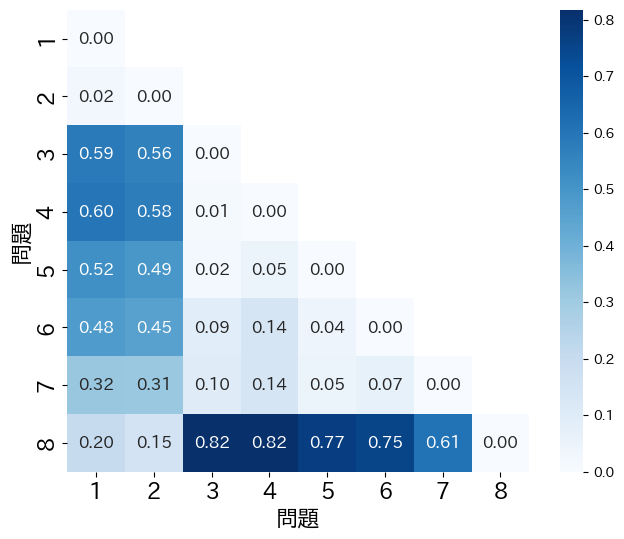

In [22]:
plt.figure(figsize=(8, 6))
mask = np.tril(np.ones((8, 8), dtype=bool), 0)
sns.heatmap(
    mmd_matrix,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    cbar=True,
    square=True,
    xticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    yticklabels=[1, 2, 3, 4, 5, 6, 7, 8],
    mask=~mask,
    annot_kws={'fontsize': 12}
)
plt.xlabel('問題', fontsize=16)
plt.ylabel('問題', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('MMD between Source and Target Prompts')
plt.savefig('outputs/figures/mmd_matrix.png')

In [29]:
mmd_vec = mmd_matrix.flatten()

In [30]:
usage_vec = normalized_arr.flatten()

In [34]:
np.corrcoef(mmd_vec, usage_vec)

array([[ 1.        , -0.15346218],
       [-0.15346218,  1.        ]])

In [33]:
np.corrcoef(mmd_vec, conmat.flatten())

array([[ 1.        , -0.30048094],
       [-0.30048094,  1.        ]])

# （実験３）曲線下面積を分析する